## 3장. 고차 미분 계산
__고차 미분이란 어떤 함수를 2번 이상 미분한 것 (역전파에 대한 역전파)__

### 26. 계산 그래프 시각화(2)

In [4]:
from dezero import Variable
from numpy import random
import numpy as np

In [5]:
#  _dot_var 보조 함수 구현하기
# 앞에 _가 붙은 이유는 로컬에서, 즉 get_dot_graph 함수 전용으로만 사용할 거여서

def _dot_var(v, verbose=False):  # verbose는 자세하게 알려줄 지
    dot_var = '{} [label="{}", color=orange, style=filled]\n'
    
    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ": "
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)  # 객체의 ID를 반환하는 함수

In [6]:
x = Variable(random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

2236819687240 [label="x", color=orange, style=filled]

2236819687240 [label="x: (2, 3) float64", color=orange, style=filled]



In [7]:
# 함수를 DOT 언어로 변환하는 함수 구현하기

def _dot_func(f):
    dot_func = '{} [label=" ", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)
    
    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y))
    return txt

In [8]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

2236814783304 [label=" ", color=lightblue, style=filled, shape=box]
2236819639560 -> 2236814783304
2236819639944 -> 2236814783304
2236814783304 -> 2236819613000



In [9]:
# get_dot_graph 함수 구현하기

def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()
    
    def add_func(f):
        if f not in seen_set:
            func.append(f)
            # funcs.sort(key=lambda x: x.generation)  # 순서는 문제가 아님
            seen_set.append(f)
            
    add_func(output.creator)
    txt += _dot_var(output, verbose)
    
    while funcs:
        func = func.pop()
        txt += _dot_func(func)
        for x in func.inputs:
            txt += _dot_var(x, verbose)
            
            if x.creator is not None:
                add_func(x.creator)
        
    return 'digraph g {\n' + txt + '}'

In [12]:
# dot 언어를 이미지로 변환하는 함수

import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)
    
    # dot 데이터를 파일에 저장
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero') 
                            # ~ 부분을 홈 디렉토리의 절대경로로 대체
    if not os.path.exists(tmp_dir): # ~/.dezero 디렉터리가 없다면 새로 생성
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')
    
    with open(graph_path, 'w') as f:
        f.write(dot_graph)
        
    # dot 명령 호출
    extension = os.path.splitext(to_file)[1][1:]  # 확장자(png, pdf 등)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)  # 외부 프로그램 호출
    
# 모든 코드를 dezero 파일의 utils.py로 넣어주기

##### 동작확인

In [13]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph

In [14]:
def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

In [15]:
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

In [16]:
x.name = 'x'
y.name = 'y'
z.name = 'z'

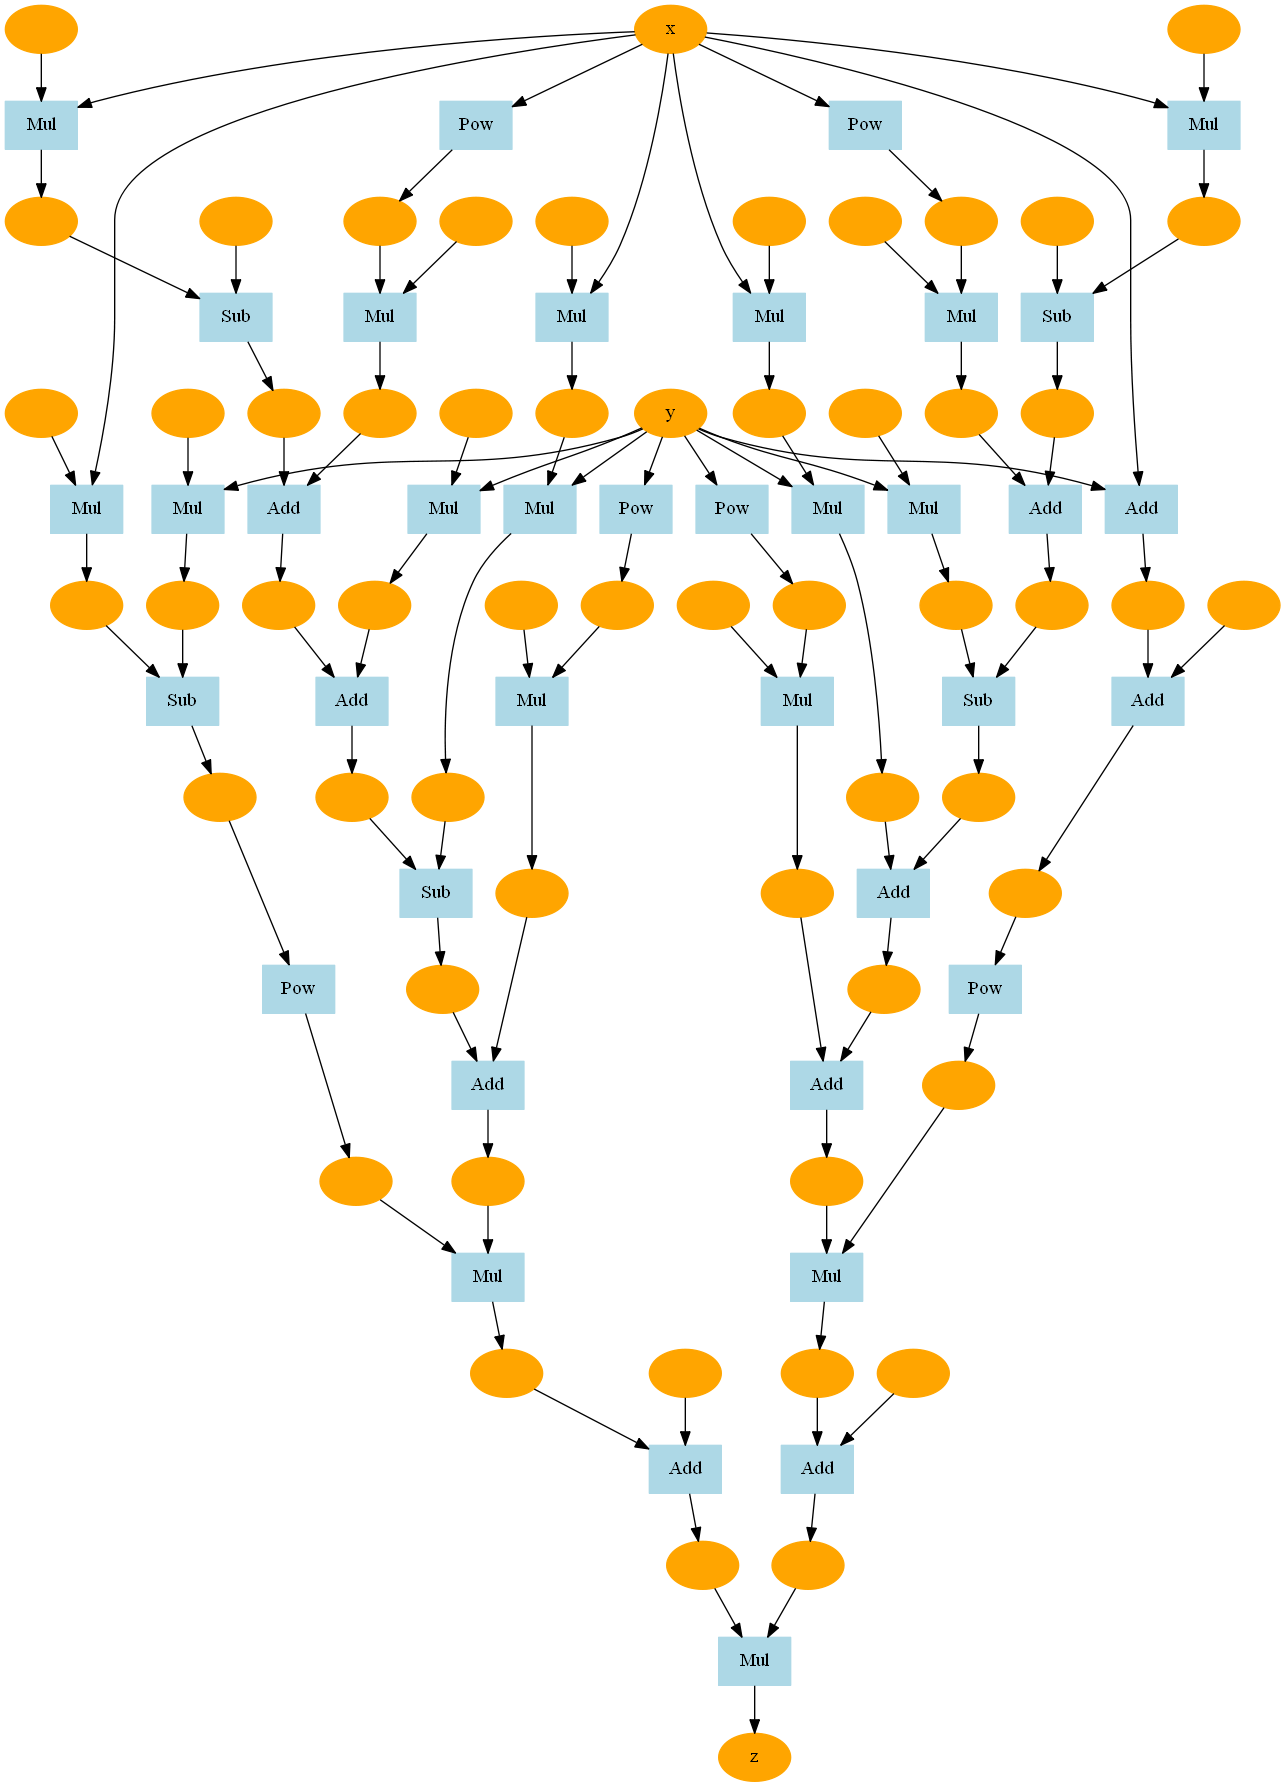

In [17]:
plot_dot_graph(z, verbose=False, to_file='img/goldstein.png')

### 27. 테일러 급수 미분
- 우선, 정공법(우리가 알고있는 sin함수의 미분 : cos함수)으로 sin함수를 Dezero로 구현하고, 그다음 그 미분을 테일러 급수를 이용해 계산해보기

#### 1) sin 함수 구현

In [18]:
from dezero import Function

In [19]:
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx

In [20]:
def sin(x):
    return Sin()(x)

In [21]:
x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()

In [22]:
print(y.data)
print(x.grad)

0.7071067811865476
0.7071067811865476


#### 2) 테일러 급수 이론
- 테일러 급수 <img src='img/27_1.png' width='400'>


- 매클로린 전개 (a=0일 때의 테일러 급수)
<img src='img/27_2.png' width='300'> <img src='img/27_3.png' width='300'>

In [41]:
import math

In [42]:
def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2*i + 1)
        t = c*x ** (2*i + 1)
        y = y + t
        if abs(t.data) < threshold: # 값이 너무 작아지면 빠져나가기
            break
    return y

In [46]:
x = Variable(np.array(np.pi / 4))
y = my_sin(x)
y.backward()
 # 여기서 backward하려면 my_sin 클래스에 back_ward 함수가 있어야 하는거 아닌가?

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


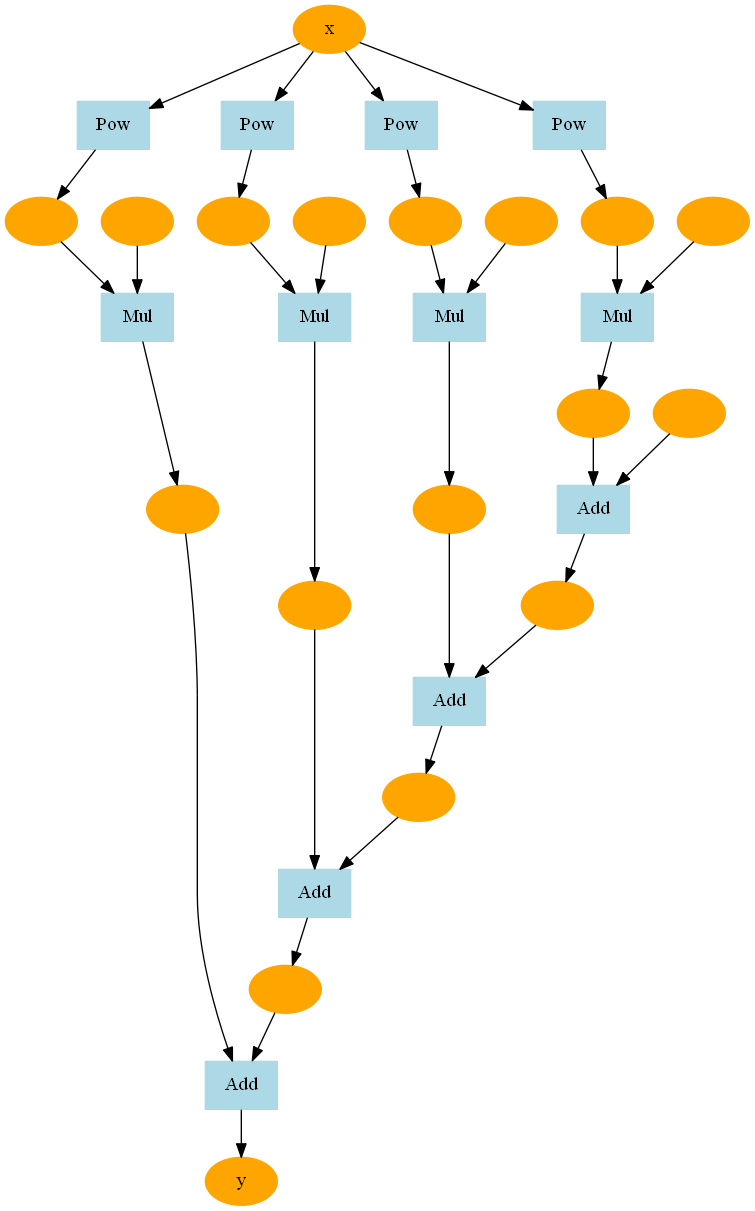

In [45]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='img/my_sin.png')

### 28. 함수 최적화
- 최적화란? 어떤 함수가 주어졌을 때 그 최솟값을 반환하는 '입력'을 찾는 일
- 미분으로 함수 최적화해보기

#### 1) 로젠브록 함수
<img src='img/28_1.png' width='200'>  
- 최솟값은 $(x_0, x_1)=(1, 1)$  
- 벤치마크 함수로 자주 사용됨 (골짜리로 향하는 기울기에 비해 골짜기 바닥에서 전역 최솟값으로 가는 기울기가 너무 작아서 최적화하기 어렵기 때문)  
<img src='img/28_2.png' width='300'>

In [25]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2
    return y

In [27]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)  # 값을 가장 크게 늘려주는 방향

-2.0 400.0


#### 3) 경사하강법 구현
- 기울기 방향으로 일정거리만큼 업데이트

In [28]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001  # 학습률
iters = 1000  # 반복횟수

for i in range(iters):
    print(x0, x1)
    
    y = rosenbrock(x0, x1)
    
    x0.cleargrad()  # 안하면 미분값이 계속 누적됨
    x1.cleargrad()
    y.backward()
    
    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

variable(0.37730248598764843) variable(0.1393545352246821)
variable(0.3780947210034542) variable(0.13995506136623762)
variable(0.37888473370446357) variable(0.14055517270312606)
variable(0.3796725346263615) variable(0.14115486644936132)
variable(0.3804581342404605) variable(0.14175413986941018)
variable(0.3812415429540969) variable(0.1423529902774746)
variable(0.3820227711110268) variable(0.1429514150367838)
variable(0.38280182899182014) variable(0.14354941155889664)
variable(0.38357872681425464) variable(0.14414697730301385)
variable(0.3843534747337082) variable(0.1447441097753)
variable(0.3851260828435503) variable(0.14534080652821504)
variable(0.38589656117553256) variable(0.14593706515985547)
variable(0.38666491970017747) variable(0.1465328833133047)
variable(0.3874311683271667) variable(0.1471282586759927)
variable(0.3881953169057274) variable(0.14772318897906483)
variable(0.38895737522501783) variable(0.1483176719967595)
variable(0.38971735301451116) variable(0.14891170554579466)

variable(0.4930032640781149) variable(0.24051037121278415)
variable(0.4935160019675662) variable(0.2410187406485624)
variable(0.4940276951894208) variable(0.24152660135846007)
variable(0.49453834747486897) variable(0.24203395380960233)
variable(0.49504796253606875) variable(0.24254079847231672)
variable(0.49555654406626837) variable(0.24304713582007595)
variable(0.49606409573992694) variable(0.24355296632944143)
variable(0.49657062121283496) variable(0.24405829048000743)
variable(0.4970761241222334) variable(0.24456310875434611)
variable(0.4975806080869322) variable(0.24506742163795328)
variable(0.4980840767074279) variable(0.24557122961919486)
variable(0.49858653356602006) variable(0.24607453318925407)
variable(0.4990879822269274) variable(0.24657733284207928)
variable(0.4995884262364026) variable(0.2470796290743326)
variable(0.5000878691228463) variable(0.24758142238533917)
variable(0.5005863143969207) variable(0.24808271327703715)
variable(0.5010837655516618) variable(0.248583502253

variable(0.5905849125958217) variable(0.3467673436824038)
variable(0.5909257953220585) variable(0.3471719827430859)
variable(0.5912661653738225) variable(0.3475762453098702)
variable(0.5916060240792014) variable(0.347980131911069)
variable(0.5919453727612418) variable(0.3483836430742153)
variable(0.5922842127379742) variable(0.34878677932606134)
variable(0.5926225453224375) variable(0.34918954119257745)
variable(0.5929603718227042) variable(0.3495919291989509)
variable(0.5932976935419044) variable(0.34999394386958466)
variable(0.5936345117782508) variable(0.3503955857280964)
variable(0.5939708278250622) variable(0.3507968552973176)
variable(0.5943066429707881) variable(0.35119775309929196)
variable(0.5946419584990325) variable(0.3515982796552751)
variable(0.5949767756885777) variable(0.3519984354857331)
variable(0.595311095813408) variable(0.3523982211103417)
variable(0.5956449201427331) variable(0.3527976370479855)
variable(0.5959782499410115) variable(0.35319668381675695)
variable(0.

variable(0.6415534151925) variable(0.40984987147081847)
variable(0.6418235528707561) variable(0.4101980540856868)
variable(0.6420933457489664) variable(0.4105459378724775)
variable(0.6423627945684597) variable(0.41089352322900236)
variable(0.6426319000682196) variable(0.4112408105523621)
variable(0.642900662984894) variable(0.4115878002389477)
variable(0.6431690840528047) variable(0.41193449268444143)
variable(0.6434371640039573) variable(0.4122808882838179)
variable(0.6437049035680509) variable(0.41262698743134546)
variable(0.6439723034724871) variable(0.4129727905205871)
variable(0.6442393644423804) variable(0.4133182979444019)
variable(0.644506087200567) variable(0.41366351009494595)
variable(0.6447724724676146) variable(0.4140084273636737)
variable(0.6450385209618313) variable(0.41435305014133916)
variable(0.6453042333992758) variable(0.41469737881799673)
variable(0.6455696104937657) variable(0.4150414137830028)
variable(0.6458346529568874) variable(0.4153851554250167)
variable(0.6

- 50,000번 하면 수렴 but 너무 과함
- 경사하강법이 로젠브록함수처럼 골짜기가 긴 함수에는 잘 대응못함

### 29. 뉴턴 방법으로 푸는 최적화(수동 계산)
<img src='img/29_1.png' width='350'>  
- 뉴턴법으로 갱신하는 경우 6회만에 끝남 (이 차이는 초깃값이나 학습률 등에 따라 크게 좌우됨)

#### 1) 뉴턴법이란?
: 테일러 급수로 2차 근사를 하여 미분해서 0 되는 최솟값 찾기를 반복하는 방법
<img src='img/29_2.png' width='250'>

#### 2) 뉴턴 방법을 활용한 최적화 구현
- 현재 DeZero는 2차 미분을 자동으로 구하지 못해 수동으로 2차 미분 계산하기  
<img src='img/29_3.png' width='100'>

In [29]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

In [30]:
def gx2(x):
    return 12 * x ** 2 - 4

In [31]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)
    
    y = f(x)
    x.cleargrad()
    y.backward()
    
    x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


<img src='img/29_4.png' width='400'>

### 30. 고차 미분(준비 편)
- 현재의 작동 방식 (데이터가 있는 경우, 상자를 노란색으로 채움)  
<img src='img/30_1.png' width='350'>  
    \- 계산의 '연결'은 Function 클래스의 \_\_call\_\_ 메서드에서 만들어짐  
    \- 구체적인 순전파와 역전파 계산은 Function 클래스를 상속한 클래스의 forward 메서드와 backward 메서드로 처리

### 31. 고차 미분(이론 편)
#### 1) 역전파 계산
- 현재, 역전파 계산을 할 때, 아무런 계산 그래프도 만들지 않음. 계산 그래프를 만들면 gx를 x로 다시 미분 할 수 있음  
=> '미분 계산'을 계산 그래프로 만들자!

#### 2) 역전파로 계산 그래프 만들기
- 역전파에서도 '연결'을 만들어 주기
- gx도 Variable 인스턴스 형태로 유지하기


<img src='img/31_1.png' width='300'>
<img src='img/31_2.png' width='300'>  
- 생략된 역전파도 표기하면 아래와 같음
<img src='img/31_3.png' width='300'>  

### 32. 고차 미분(구현 편)

#### 1) DeZero 수정하기
- Variable 클래스의 backward 함수에서 grad 초기화 부분 수정  
self.grad = np.ones_like(self.data)) -> self.grad = Variable(np.ones_like(self.data))

#### 2) 함수 클래스 역전파
- 함수들의 backward 메서드 수정하기
- gy가 Variable 인스턴스이므로 직접 gy * x1로 해주기  
<img src='img/32_1.png' width='400'>

#### 3) 역전파를 더 효율적으로 (모드 추가)
- 18단계에서 역전파 활성/비활성 모드를 구현한 것 처럼,  
역전파 계산도 비활성 모드로 실행하도록 구현하기 (Variable 클래스의 backward 메서드 수정)

In [32]:
# ### 18단계 역전파 활성/비활성 모드 구현 코드
# class Config:
#     enable_backprop = True

# @contextlib.contextmanager
# def using_config(name, value):
#     old_value = getattr(Config, name)  # Config.name 값
#     setattr(Config, name, value)  # Config.name 값  value값으로 넣어주기
#     try:
#         yield
#     finally:
#         setattr(Config, name, old_value)

# ### with문 간단히하기
# def no_grad():
#     return using_config('enable_backprop', False)

# with no_grad():
#     x = Variable(np.array(2.0))
#     y = square(x)

- Variable 클래스의 backward 메서드에 다음 코드 추가하기
<img src='img/32_2.png' width='400'>

#### 4) __init__.py 변경
<img src='img/32_3.png' width='400'>

### 33. 뉴턴 방법으로 푸는 최적화(자동 계산)
#### 1) 2차 미분 계산하기

In [1]:
import numpy as np
from dezero import Variable

In [5]:
def f(x):
    y = x ** 4 - 2*x ** 2
    return y

In [6]:
x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

# 두 번째 역전파 진행
gx = x.grad
gx.backward()  # 잘못됨(미분값이 있는 상태에서 역전파를 수행하여 미분값이 '더해짐')
print(x.grad)

variable(24.0)
variable(68.0)


In [7]:
# 미분값 재설정
x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad()  # 미분값 재설정
gx.backward()  
print(x.grad)

variable(24.0)
variable(44.0)


#### 2) 뉴턴 방법을 활용한 최적화
<img src='img/33_1.png' width='150'>

In [8]:
import numpy as np
from dezero import Variable

In [9]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

In [10]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)
    
    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)
    
    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad
    
    x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### 34. sin 함수 고차 미분

#### 1) sin 함수 구현

In [12]:
import numpy as np
from dezero.core import Function

In [14]:
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x)
        return gx
    
def sin(x):
    return Sin()(x)

#### 2) cos 함수 구현

In [15]:
class Cos(Function):
    def forward(self, x):
        y = np.cos(x)
        return y
    
    def backward(self, gy):
        x, = self.inputs
        gx = gy * -sin(x)
        return gx
    
def cos(x):
    return Cos()(x)

#### 3) sin 함수 고차 미분

In [8]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [2]:
x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

variable(-0.8414709848078965)
variable(-0.5403023058681398)
variable(0.8414709848078965)


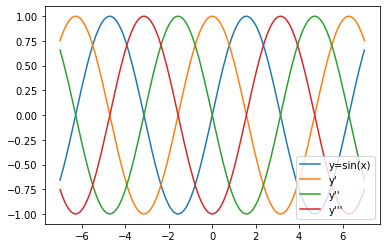

In [4]:
# 위 코드를 확장하여 그래프 그려보기
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

# 그래프 그리기
labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

### 35. 고차 미분 계산 그래프

#### 1) tanh 함수
<img src='img/35_1.png' width='150'>

- 미분
<img src='img/35_2.png' width='300'>

#### 2) tanh 함수 구현

In [7]:
class Tanh(Function):
    def forward(self, x):
        y = np.tanh(x)
        return y
    
    def backard(self, gy):
        y = self.outputs[0]()
        gx = gy * (- y*y)
        return gx
    
def tanh(x):
    return Tanh()(x)

#### 3) 고차 미분 계산 그래프 시각화

In [4]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

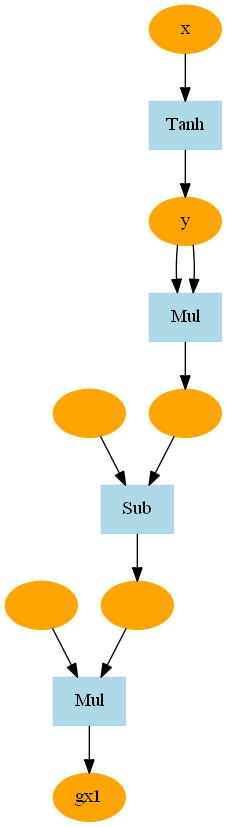

In [11]:
x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 0

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    
# 계산 그래프 그리기
gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='img/tanh.png')

### 36. 고차 미분 이외의 용도

#### 1) double backprop의 용도
<img src='img/36_1.png' width='450'>
<img src='img/36_2.png' width='250'>

In [6]:
import numpy as np
from dezero import Variable

In [13]:
x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)  # 미분을 하기 위해 역전파 
                                # 2차 이상의 미분이 필요한 경우 True로!
gx = x.grad
x.cleargrad()

z = gx ** 3 + y   # gx = x.grad는 단순한 변수가 아니라 계산 그래프(식)
z.backward()
print(x.grad)

variable(100.0)


#### cf) 뉴턴 방법
- x가 벡터일 때, 뉴턴 방법은 아래와 같아짐

<img src='img/36_3.png' width='150'>

- 하지만, 헤시안 행렬의 역행렬 계산에 자원이 많이 소모되므로 준 뉴턴 방법(QNM)이 대안으로 사용됨. 다만 지금까지 딥러닝 분야에서 주류는 기울기만을 사용한 최적화(SGD, 모멘텀, Adam 등)이라서 QNM를 잘 사용되지 않음

#### cf) double backprop의 용도 : 헤시안 행렬과 벡터의 곱
- 헤시안 행렬의 계산 비용은 크지만, 헤시안 행렬과 벡터의 곱의 '결과'만 필요하다면 double backprop을 이용하여 효율적으로 구할 수 있음

<img src='img/36_4.png' width='150'>
<pre>
                     (좌변 : 헤시안 행렬과 벡터v의 곱)
</pre>
<img src='img/36_5.png' width='200'>

In [13]:
# 직접 계산해 보기

x = Variable(np.array([1.0, 2.0]))
v = Variable(np.array([4.0, 5.0]))

def f(x):
    t = x ** 2
    y = F.sum(t)
    return y

y = f(x)
y.backward(create_graph=True)

gx = x.grad
x.cleargrad()

z = F.matmul(v, gx)
z.backward()
print(x.grad)

AttributeError: 'Variable' object has no attribute 'reshape'